<a href="https://colab.research.google.com/github/OussamaLafdil/CNN-CancerDetection/blob/main/Xception_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import os


In [ ]:
from  google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
Augmented_Dataset

In [ ]:

# Chemins vers les répertoires des images
augmented_data_path = '/content/drive/MyDrive/Augmented_Dataset/Augmented_Dataset'


class_labels = os.listdir(augmented_data_path)
print(f"Class Labels: {class_labels}")

Class Labels: ['Early', 'Benign', 'Pro', 'Pre']


In [ ]:

image_paths = []
labels = []

# get the image paths and labels
for label in class_labels:
    folder_path = os.path.join(augmented_data_path, label)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image_paths.append(image_path)
        labels.append(label)

class_counts = Counter(labels)

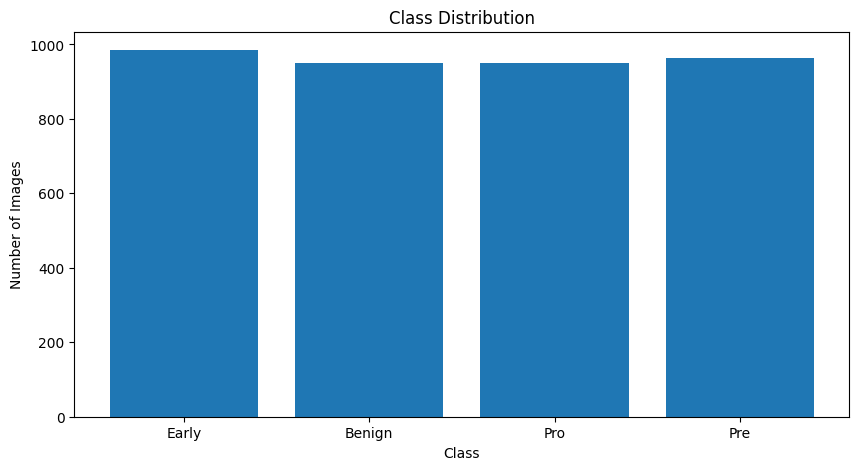

In [ ]:

# plot the distribution of classes
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
image_arrays = []
for img_path in image_paths:
    with Image.open(img_path) as img:
        img = img.resize((224, 224))  # not necessary
        image_arrays.append(np.array(img))

all_images = np.stack(image_arrays)
mean_pixel = np.mean(all_images)
std_pixel = np.std(all_images)

print(f"Mean pixel value: {mean_pixel}")
print(f"Standard deviation of pixel values: {std_pixel}")

Mean pixel value: 224.65293444966994
Standard deviation of pixel values: 34.38220858907581


In [ ]:
from pathlib import Path
from pathlib import Path
import os
from collections import defaultdict
main_output_folder = 'Augmented_Dataset'
class_labels = ['Benign', 'Early', 'Pre', 'Pro']

# create directories
for label in class_labels:
    Path(os.path.join(main_output_folder, label)).mkdir(parents=True, exist_ok=True)

class_counters = defaultdict(int)

# save original and augmented images
for img_array, label in zip(image_arrays, labels):
    img = Image.fromarray(img_array)
    class_counters[label] += 1
    img_name = f"{label}_{class_counters[label]:04d}.jpg"
    img_path = os.path.join(main_output_folder, label, img_name)
    img.save(img_path)

In [ ]:
class_names = list(set(labels))
label_to_index = {label: index for index, label in enumerate(class_names)}
labels_encoded = [label_to_index[label] for label in labels]
labels_categorical = to_categorical(labels_encoded, num_classes=len(class_names))

In [ ]:
labels_categorical = labels_categorical[:len(image_arrays)]


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(np.array(image_arrays), np.array(labels_categorical
                                                                                     ), test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Charger le modèle Xception sans la couche de classification finale
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajouter une couche de pooling global pour obtenir un vecteur de caractéristiques
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Créer un modèle d'extraction de caractéristiques
feature_extractor_model = Model(inputs=base_model.input, outputs=x)

# Résumé du modèle d'extraction de caractéristiques
feature_extractor_model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
# freeze the layers of the base model to keep the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.layers import Dropout
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

In [ ]:
# final Model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)



history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6904 - loss: 4.0644
Epoch 1: val_accuracy improved from -inf to 0.95494, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 56s 466ms/step - accuracy: 0.6919 - loss: 4.0355 - val_accuracy: 0.9549 - val_loss: 0.1415
Epoch 2/30
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9235 - loss: 0.2383
Epoch 2: val_accuracy improved from 0.95494 to 0.96880, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 70s 474ms/step - accuracy: 0.9236 - loss: 0.2386 - val_accuracy: 0.9688 - val_loss: 0.1124
Epoch 3/30
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9196 - loss: 0.2447
Epoch 3: val_accuracy improved from 0.96880 to 0.97574, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 59s 699ms/step - accuracy: 0.9198 - loss: 0.2437 - val_accuracy: 0.9757 - val_loss: 0.0997
Epoch 4/30
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9546 - loss: 0.1422
Epoch 4: val_accuracy did not improve 

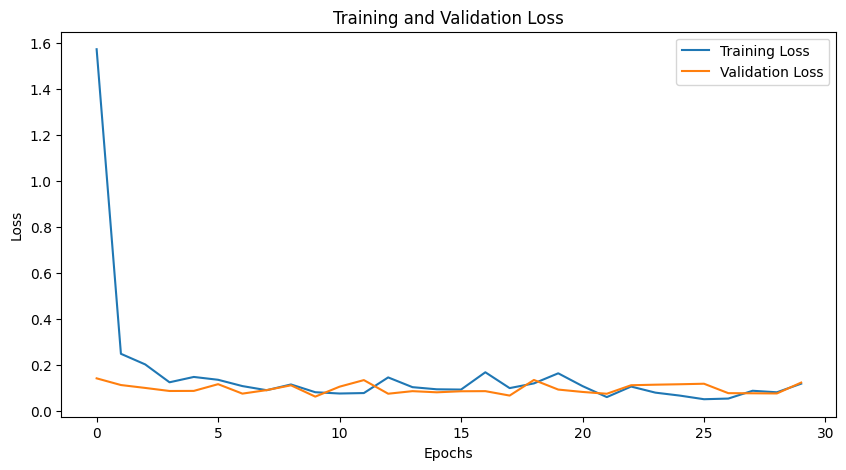

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step
Classification Report:
               precision    recall  f1-score   support

         Pro       0.99      0.99      0.99       140
         Pre       0.99      0.98      0.99       132
       Early       0.96      1.00      0.98       145
      Benign       0.99      0.97      0.98       161

    accuracy                           0.98       578
   macro avg       0.98      0.98      0.98       578
weighted avg       0.98      0.98      0.98       578



In [ ]:
best_model = load_model('best_model.keras')


In [ ]:
# evaluate the model on validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.9831 - loss: 0.0813
Validation Accuracy: 98.27%


In [ ]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 511ms/step
Classification Report:
               precision    recall  f1-score   support

         Pro       0.99      0.96      0.98       140
         Pre       0.98      0.99      0.99       132
       Early       0.95      0.99      0.97       145
      Benign       0.97      0.96      0.97       161

    accuracy                           0.98       578
   macro avg       0.98      0.98      0.98       578
weighted avg       0.98      0.98      0.98       578



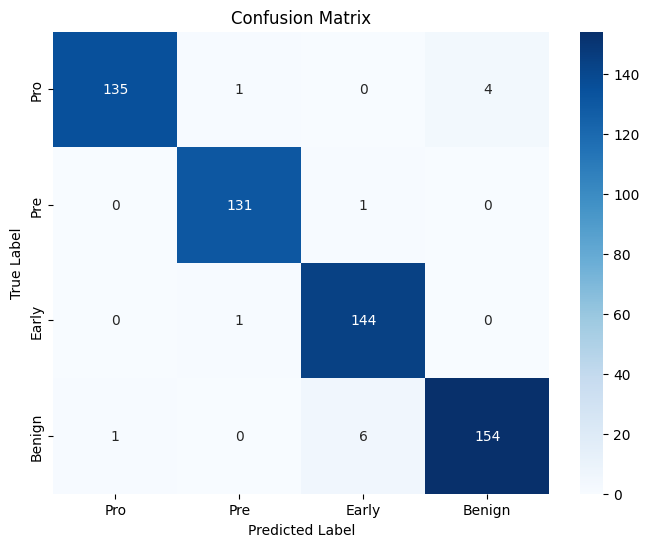

In [ ]:

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()